In [12]:
import random
import numpy as np
from tqdm import trange

In [13]:
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    return sigmoid(z)*(1-sigmoid(z))

def vectorized_result(n):
    e = np.zeros((10, 1))
    e[n] = 1.0
    return e

class QuadraticCost(object):
    @staticmethod
    def fn(a, y):
        return 0.5*np.linalg.norm(a-y)**2

    @staticmethod
    def delta(z, a, y):
        return (a-y) * sigmoid_prime(z)

class CrossEntropyCost(object):
    @staticmethod
    def fn(a, y):
        return np.sum(np.nan_to_num(-y*np.log(a)-(1-y)*np.log(1-a)))

    @staticmethod
    def delta(z, a, y):
        return (a-y)

In [14]:
class Network(object):
    def __init__(self, sizes, cost=CrossEntropyCost):
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]
        self.cost = cost

    def feedforward(self, a):
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a
    
    def SGD(self, training_data, epochs, mini_batch_size=10, lr=0.10, lmbda = 0.0):
        n = len(training_data)
        training_cost, training_accuracy = [], []

        for j in (t := trange(epochs)):
            random.shuffle(training_data)
            mini_batches = [training_data[k:k+mini_batch_size] for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, lr, lmbda, len(training_data))

            cost = self.total_cost(training_data, lmbda)
            training_cost.append(cost)

            accuracy = self.accuracy(training_data, convert=True)
            training_accuracy.append(accuracy/n)

            t.set_description("loss %.2f accuracy %.2f" % (cost, accuracy/n))

        return training_cost, training_accuracy
    
    def update_mini_batch(self, mini_batch, eta, lmbda, n):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [(1-eta*(lmbda/n))*w-(eta/len(mini_batch))*nw for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb for b, nb in zip(self.biases, nabla_b)]
        
    def backprop(self, x, y):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]

        # feedforward
        activation = x
        activations = [x]
        zs = []
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)

        # backward
        delta = (self.cost).delta(zs[-1], activations[-1], y)
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())

        return (nabla_b, nabla_w)
    
    def accuracy(self, data, convert=False):
        if convert:
            results = [(np.argmax(self.feedforward(x)), np.argmax(y)) for (x, y) in data]
        else:
            results = [(np.argmax(self.feedforward(x)), y) for (x, y) in data]
        result_accuracy = sum(int(x == y) for (x, y) in results)
        return result_accuracy
    
    def total_cost(self, data, lmbda, convert=False):
        cost = 0.0
        for x, y in data:
            a = self.feedforward(x)
            if convert: y = vectorized_result(y)
            cost += self.cost.fn(a, y)/len(data)
            cost += 0.5*(lmbda/len(data))*sum(np.linalg.norm(w)**2 for w in self.weights)
        return cost
    
    def evaluate(self, test_data):
        test_results = [(np.argmax(self.feedforward(x)), y) for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)

In [15]:
import pandas as pd

data = np.array(pd.read_csv('data/train.csv'))
m, n = data.shape
print(m, n)

42000 785


In [16]:
x_train = [np.reshape(r[1:n]/255., (n-1, 1)) for r in data[0:int(m*0.9)]]
y_train = [vectorized_result(r[0]) for r in data[0:int(m*0.9)]]
training_data = list(zip(x_train, y_train))

x_test = [np.reshape(r[1:n]/255., (n-1, 1)) for r in data[int(m*0.9):m]]
y_test = [r[0] for r in data[int(m*0.9):m]]
test_data = list(zip(x_test, y_test))

In [21]:
net = Network([784, 10, 10])
losses, accuracies = net.SGD(training_data=training_data, epochs=20, lr=0.10)

loss 0.53 accuracy 0.92: 100%|██████████| 20/20 [00:49<00:00,  2.46s/it]


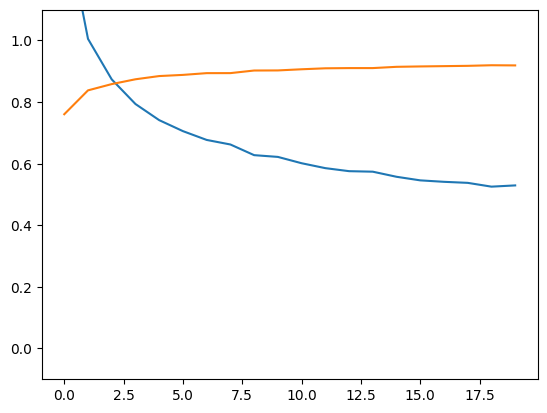

In [22]:
import matplotlib.pyplot as plt

plt.ylim(-0.1, 1.1)
plt.plot(losses)
plt.plot(accuracies)

In [23]:
test_results = [(np.argmax(net.feedforward(x)), y) for (x, y) in test_data]
correct_pred = sum(int(x == y) for (x, y) in test_results)
correct_pred/len(test_results)

0.9095238095238095

[14]# Label: 3 | Pred: 8


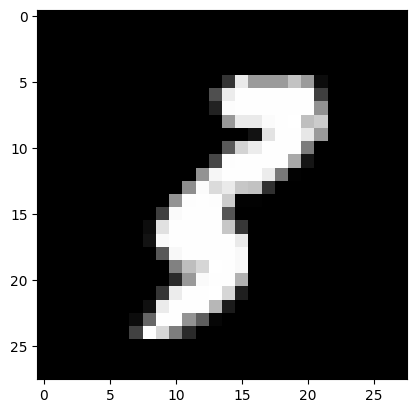

In [24]:
# Check first label and prediction difference

for idx in range(len(test_results)):
    pred_ = test_results[idx][0]
    label_ = test_results[idx][1]

    if pred_ != label_:
        print(f"[{idx}]# Label: {label_} | Pred: {pred_}")
        current_image = test_data[idx][0].reshape((28, 28)) * 255
        plt.gray()
        plt.imshow(current_image, interpolation='nearest')
        plt.show()
        break

4

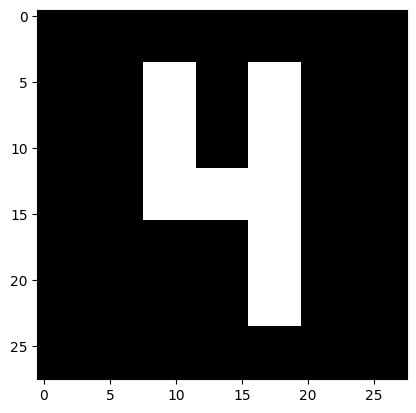

In [25]:
# Check prediction for manually inserted label

m = [[0,0,0,0,0,0,0],
     [0,0,1,0,1,0,0],
     [0,0,1,0,1,0,0],
     [0,0,1,1,1,0,0],
     [0,0,0,0,1,0,0],
     [0,0,0,0,1,0,0],
     [0,0,0,0,0,0,0]]
m = np.concatenate([np.concatenate([[x]*4 for x in y]*4) for y in m])
plt.imshow(m.reshape(28,28))
np.argmax(net.feedforward(m.reshape(784, 1)))